# DQN With `CartPole-v1`

In this notebook, I'll be attempting to implement my own DQN and train it (successfully) on the `gym` environment `CartPole-v1`. Let's take a look at the game and it's rewards before we go ahead and try anything. 

UGH. Turns out I have to install the environments (Atari, Box2D, etc.) before I use games in those environments. Off I go. 

...And I'm back! Side note: to install the different environments, you must clone the git repository `openai/gym.git`, `cd` to the project directory, and *then* do `pip install -e '.[atar]'` (or `[box2d]`, etc.). I had previously just used `pip install gym`, so I wasn't in the right directory for running the install command. 

Okay, back to business. Let's start the environment, run a random sequence and see what the different outputs look like. 

[2017-11-21 16:34:05,428] Making new env: CartPole-v1


action 0
action space Discrete(2)
observation [-0.04307656 -0.1886435  -0.00991309  0.32825525]
observation_space Box(4,)
reward 1.0
done False
info {}


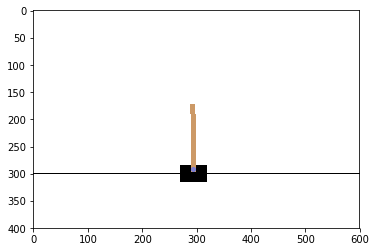

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot
import gym

env = gym.make('CartPole-v1')
observation = env.reset()
np_img = env.render(mode='rgb_array')
env.render(close=True)
pyplot.imshow(np_img)
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
print('action', action)
print('action space', env.action_space)
print('observation', observation)
print('observation_space', env.observation_space)
print('reward', reward)
print('done', done)
print('info', info)

Note: at least for CartPole, calling `env.render(...)` with or without parameters opens up a new window that can't be closed. According to [this](https://github.com/openai/gym/issues/3) discussion, the solution is simply to call `env.render(close=True)` immediately after making the first call. 

So, we can see the environment's rendered output: a 400x600 array containing the cart and a line representing the ground. The observations are a series of four floats (not sure what they mean). The action space is discrete (see [Spaces](https://gym.openai.com/docs/)), telling it to go either left or right. It doesn't matter which is which for a DQN--but for our own purposes, let's look at the [source](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py). ...Okay, so `action=1` means a positive force, and `action=0` means a negative force applied. I assume the positive direction is to the right, at least in our image. Let's test this. 

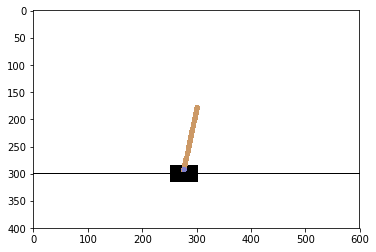

In [2]:
_, _, done, _ = env.step(action)
while not done:
    _, _, done, _ = env.step(action)
np_img = env.render(mode='rgb_array')
env.render(close=True)
pyplot.imshow(np_img)

So, based on the visual evidence, 0 means 'apply force to left' and 1 means 'apply force to right'. 

Now we need to know what these four observation values mean, and how they are relevant. ...Okay, looking at the source doesn't seem to help. I see the state returned as `x, x_dot, theta, theta_dot`...which doesn't help much. However, according to [this](https://github.com/openai/gym/issues/238) discussion, we're not supposed to care what they are. That being said...they represent the position $x$, the derivative of position w.r.t. time $x'$, the pole's angle $\theta$, and the derivative w.r.t. time of the pole's angle $\theta'$. 

In any case, here are the ranges of the observation's output. 

In [3]:
print('observation float max', env.observation_space.high)
print('observation float min', env.observation_space.low)

observation float max [  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
observation float min [ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]


Okay...that doesn't help us. Let's ignore these values then, and simply use the image as input, with no other options. Cool! Another step forward. 

Next order of business: reward. As per `CartPole-v1`'s [description](https://gym.openai.com/envs/CartPole-v1/):

> A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

We'll have to think about this carefully. It seems like always receiving a reward of +1 will prevent proper learning, because there will be no difference in reward for any actions performed. This is a problem, and we will think about it later. 

Alright, now that we've got the exploration phase out of the way and have a handle on our framework, Let's review what Google's [Atari paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) did, in detail:
* RMSProp variant of SGD;
* frame-skipping (input every $k^{\mathrm{th}}$ frame; most recent input is repeated for intermediate frames; $k=4$);
* standard Q-learning algorithm, but with replay memory (randomly sampling minibatch of size 32 from the last $N$ transitions) and fixing the target policy for $c$ gradient descent steps before updating the target policy with the most recent parameters;
* use a modified loss function $min(|\mathrm{Q-learning error}|, (\mathrm{Q-learning error})^2$;
* $\epsilon$-greedy decision output, with $\epsilon$ annealed linearly from 0.9 to 0.1 over the first 1 million frames, fixed at 0.1 afterwards (greedy probability $1-\epsilon$, and random with probability $\epsilon$);
* use the last $m$ pre-processed frames as input ($m=4$);
* trained for 50 million frames (roughly 38 days of play time) total.

We will try to stick as closely as possible to what they did, with a few exceptions:
* looking at the source for CartPole-v1 shows that it runs at 50 frames-per-second; Deepmind's Atari paper said that the average human button-press response is 10Hz, so we'll set $k=5$;
* our replay memory will be much smaller, limited by the memory constraints on my laptop;
* we'll train for far less frames (we'll see how patient I am), because (1) the task is simpler, and (2) we're starting from a network pretrained on imagenet;
* our preprocessing step will be different from theirs, obviously (we'll consider only the relevant parts of the image: pixels 300:178 row-wise, and the whole image column-wise; then we'll rescale to 224x224 because we're using something pretrained on imagenet; these values were obtained by examining the function `_step(...)` in the CartPole-v1 source code);
* since we're using a network trained on imagenet, our network's input (i.e., one observation) will be the difference between the current frame and the previous frame, allowing for some use of image velocity/image gradient. 

A thought, regarding the problem of always receiving a +1 reward during training: there is a solution! If we look at CartPole-v1's source code, we see the following code in the `.step(...)` function:

```python
if not done:
    reward = 1.0
elif self.steps_beyond_done is None:
    # Pole just fell!
    self.steps_beyond_done = 0
    reward = 1.0
else:
    if self.steps_beyond_done == 0:
        logger.warning("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
    self.steps_beyond_done += 1
    reward = 0.0
```

We *could* run the algorithm for a few steps after the episode is officially done, so that we see a difference in reward (and hopefully the estimated state-action utilities start to flow backward from those states). We don't want to run the algorithm for too long after this point, however, because there is a chance that the algorithm may be doing correct steps to right itself--which would then be labeled as negative, regardless of whether the conditions for a positive reward (as specified in CartPole's official description) were being met or not. Further, after `done` is `True`, we have undefined behavior in the environment. 

So, instead, we will do something simpler: in our code, if `done` is returned as `True`, then we will modify the reward to be 0. (Depending on how things go, we may have to provide a more powerful reward of -1.)

Whew! That was quite a bit of thinking. Let's dive back into PyTorch and get a DQN up and running. First, let's define our `ReplayMemory`. 

In [1]:
import random

import typing
import torch

class Transition(typing.NamedTuple):
    prev_state: typing.Union[torch.cuda.FloatTensor]
    prev_action: int
    prev_reward: float
    cur_state: typing.Union[torch.cuda.FloatTensor]
    end_transition: bool

class ReplayMemory(object):
    capacity: int
    memory: typing.List[Transition]
    position: int
    
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, transition: Transition):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size: int) -> typing.Iterable[Transition]:
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

Now that we've got our transition replay memory, we're going to create our neural network. As mentioned very briefly before, in order to speed things up, we will start with an existing model trained for object recognition. Because it's small, let's use `resnet18` pretrained on ImageNet, and add a linear layer on top to convert from the ImageNet classes to our left/right output. 

In [5]:
import torch.nn as nn
import torchvision.models as models

class PretrainedResNet18(nn.Module):
    def __init__(self):
        super(PretrainedResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(1000, 2)
    
    def forward(self, x):
        x = self.relu(self.resnet18(x))
        x = self.fc(x)
        return x

<Container object of 2 artists>

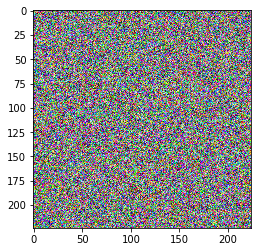

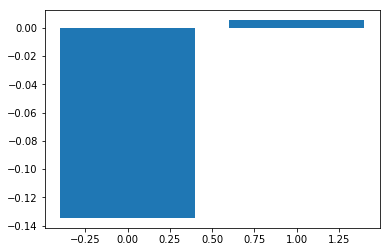

In [6]:
import torch.autograd as autograd
import numpy

net = PretrainedResNet18()

random_input = autograd.Variable(torch.rand(1, 3, 224, 224))
pyplot.imshow(random_input.data.permute(0, 2, 3, 1).squeeze().numpy())
pyplot.figure()
pyplot.bar(numpy.array([0, 1]), net(random_input).data.squeeze().numpy())

As you can see, we have the predicted (albeit nonsensical) rewards for our random image. Good stuff! (Side note: just spent better part of half an hour debugging the call to `pyplot.bar(...)`, only to realize that I wasn't squeezing my network output to get rid of the batch dimension. Whoops!)

Before we move on to the learning loop, it's pertinent to consider what I want to experiment with in this notebook. Here are a few ideas.

* Sampling: does the random sampling of transition history really affect performance that much? If so, why? Can we come up with a better sampling method?
* How much is the performance affected by whether or not we use the image *difference* (as opposed to the actual image) as the observation?

We can answer the second question more easily. However, first we want to try getting good performance at all--so we'll leave everything as we discussed previously.

Now, the training loop. 


 1
 4
 5
[torch.FloatTensor of size 3]


 2
 4
 6
[torch.FloatTensor of size 3]


 0  0
[torch.ByteTensor of size 1x2]


 1
 0
[torch.ByteTensor of size 2]

no can do cowboy

 1
 0
[torch.FloatTensor of size 2]


 1
 2
 3
 4
 5
 6
[torch.FloatTensor of size 6]


  1   4
  9  16
[torch.FloatTensor of size 2x2]

can't do that! but I can do this...
torch.Size([3, 224, 224])


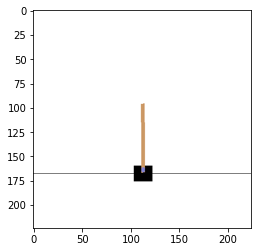

In [7]:
temp = torch.FloatTensor([[1, 2], [3, 4], [5, 6]])
print(temp[torch.ByteTensor([[True, False], [False, True], [True, False]])])
# So we can use a boolean indexing mask to get only the Q-values we want. 
print(temp.max(1)[0])
# So argument to Tensor.max() is the dimension along which we're taking the max.
print(torch.zeros(1, 2).byte())
print(torch.ByteTensor([True, False]))
# So ByteTensor as an index is literally a multiplicative mask?
try:
    print(torch.ones(3)[torch.ByteTensor([1, 2, 3])])
except:
    print("no can do cowboy")
# Ah! Only a boolean (1 or 0) mask allowed in indexing--but ByteTensors can, in general, take any byte value. 
print(torch.FloatTensor([True, False]))
# So we can make a float tensor out of true/false values. Cool. 
print(torch.cat([torch.Tensor([1, 2, 3]), torch.Tensor([4, 5, 6])]))
# So torch.cat(...) takes a list of tensors.
print(torch.Tensor([[1, 2], [3, 4]])**2)
# Squaring is, apparently, element-wise. 
try:
    torch.Tensor(env.render(mode='rgb_array')).size()
except:
    print("can't do that! but I can do this...")
import torchvision.transforms as transforms
import PIL
resize = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Scale((224, 224), interpolation=PIL.Image.CUBIC),
     transforms.ToTensor()])
env.reset()
print(resize(env.render(mode='rgb_array')).size())
pyplot.imshow(resize(env.render(mode='rgb_array')).permute(1, 2, 0).numpy())
env.render(close=True)
# Something something "negative strides aren't supported", so I have to transform it using tochvision and PIL

In [ ]:
import copy

import torch.autograd as autograd
import torch.optim as optim

class CartPoleDQNContext(object):
    replay_memory: ReplayMemory
    env: gym.Env
    net: nn.Module
    optimizer: torch.optim
    prev_screen: torch.Tensor
    
    def __init__(self, memory_size: int, cuda: bool):
        self.cuda = cuda
        self.env = gym.make('CartPole-v1')
        self.replay_memory = ReplayMemory(memory_size)
        self.net = PretrainedResNet18()
        self.targetnet = PretrainedResNet18()
        self.targetnet.load_state_dict(self.net.state_dict())
        if self.cuda:
            self.net.cuda()
            self.targetnet.cuda()
        self.optimizer = optim.RMSprop(self.net.parameters(), lr=0.1, weight_decay = 0.001)
        self.batch_size = 32
        self.c = 100
        self.resize = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.Scale((224, 224), interpolation=PIL.Image.CUBIC),
             transforms.ToTensor()])
        self.discount_factor = 0.99
        self.num_steps_with_current_target = 0
        self.init_epsilon = 0.1
        self.final_epsilon = 0.9
        self.anneal_length = 100000
        self.num_steps = 0
    
    def run_episode(self, close=True, pause=0.0):
        self.env.reset()
        prev_screen = self.get_screen(close)
        prev_state = self.get_screen(close)
        prev_action = self.choose_action(prev_state)
        _, prev_reward, done, _ = self.env.step(prev_action)
        
        while not done:
            cur_screen = self.get_screen(close)
            cur_state = cur_screen - prev_screen
            
            cur_epsilon = self.init_epsilon + (self.final_epsilon - self.init_epsilon)*self.num_steps/self.anneal_length
            if random.random() > 1 - cur_epsilon:
                cur_action = self.env.action_space.sample()
            else:
                cur_action = self.choose_action(cur_state)
            
            _, cur_reward, done, _ = self.env.step(cur_action)
            if done:
                cur_reward = -1 # Modified because of problem with constant reward. 
            else:
                cur_reward = 0.1
            
            # Add transition.
            self.replay_memory.push(Transition(prev_state=prev_state,
                                               prev_action=prev_action,
                                               prev_reward=prev_reward,
                                               cur_state=cur_state,
                                               end_transition=False))
            
            # If we're done, we also need to add the next Transition with an end state.
            if done:
                self.replay_memory.push(Transition(prev_state=cur_state,
                                                   prev_action=cur_action,
                                                   prev_reward=cur_reward,
                                                   cur_state=self.get_screen(close),
                                                   end_transition=True))
            # Now that we've added transitions, we can sample self.batch_size number of replay transitions
            # and perform a step in the optimizer.
            cur_batch_size = min(len(self.replay_memory), self.batch_size)
            transitions = self.replay_memory.sample(cur_batch_size)
            states, actions, rewards, next_states, end_transitions = zip(*transitions)
            
            states = autograd.Variable(torch.cat([state.unsqueeze(0) for state in states])) # Add batch dim to each sample.
            rewards = autograd.Variable(torch.cat([torch.Tensor([reward]) for reward in rewards]))
            end_transitions = autograd.Variable(torch.Tensor(end_transitions).float())
            next_states = autograd.Variable(torch.cat([next_state.unsqueeze(0) for next_state in next_states]))
            
            if self.cuda:
                states = states.cuda()
                next_states = next_states.cuda()
                rewards = rewards.cuda()
                end_transitions = end_transitions.cuda()
            
            actions_mask = torch.zeros(cur_batch_size, 2).byte()
            for sample_index, action in enumerate(actions):
                actions_mask[sample_index, action] = 1
            actions_mask = actions_mask.cuda()
            
            target_qvalues = self.targetnet(next_states)[actions_mask].cuda()
            current_qvalues, _ = self.net(states).max(1)
            
            error = torch.sum(
                (rewards + self.discount_factor*target_qvalues*end_transitions - current_qvalues)**2)/cur_batch_size
            self.optimizer.zero_grad()
            error.backward()
            self.optimizer.step()
            self.num_steps_with_current_target += 1
            if self.num_steps_with_current_target == self.c:
                self.targetnet.load_state_dict(self.net.state_dict())
                self.num_steps_with_current_target = 0
            
            # After all that is done, we reset our context variables for the next iteration.
            prev_screen = cur_screen
            prev_state = cur_state
            prev_action = cur_action
            prev_reward = cur_reward
            
            self.num_steps += 1
            
            if not close:
                import time
                time.sleep(pause)
    
    def get_screen(self, close):
        screen = self.resize(self.env.render(mode='rgb_array')).float()/255.0
        if close:
            self.env.render(close=True)
        return screen
    
    def choose_action(self, observation: torch.Tensor) -> typing.Tuple[autograd.Variable, int]:
        """Returns the action chosen by the network."""
        network_input = autograd.Variable(observation.unsqueeze(0))
        if self.cuda:
            network_input = network_input.cuda()
        value, index = self.net(network_input).max(1)
        return index.data[0]

Okay, so some of the code might seem...random, at first glance, to whomever reads this in the future. Here's the rationale. 

Rendering the window every time seems to take too long. So, I added code to close the window every time it renders a screen. Now we will test how long each method takes.

In [ ]:
import datetime

t1 = datetime.datetime.now()
training_context = CartPoleDQNContext(10000, True)
for i in range(100):
    training_context.run_episode(close=True)
t2 = datetime.datetime.now()
print("Closing the window: 100 epsidoes takes " + str(t2 - t1) + ".")

t1 = datetime.datetime.now()
training_context = CartPoleDQNContext(10000, True)
for i in range(100):
    training_context.run_episode(close=False)
t2 = datetime.datetime.now()
print("Leaving the window open: 100 epsidoes takes " + str(t2 - t1) + ".")

[2017-11-21 16:34:08,335] Making new env: CartPole-v1


Hmmm. Leaving the window open seems to do be fastest--which, in retrospect, makes sense, since it involves many fewer underlying calls to the OS for opening/closing windows. 

Let's get an average time per episode. As a side note, we will also plot the time it takes for each episode as we continue iterations. If it gets worse, then the size of the replay memory might be affecting performance. 

In [ ]:
training_context = CartPoleDQNContext(10000, True)
times = []
for i in range(100):
    t1 = datetime.datetime.now()
    training_context.run_episode(close=False)
    t2 = datetime.datetime.now()
    times.append(t2 - t1)
times = [time.total_seconds() for time in times]
pyplot.plot(times)

So it doesn't seem to be getting worse, at least over the first 100 episodes. Something else I'd like to know: how many iterations of SGD are we getting per episode? Also, how much of the time we plotted above is due to rendering, and how much of it is due to network computation? Let's do an experiment. 

In [ ]:
training_context = CartPoleDQNContext(10000, True)
iterations = [0]
for i in range(100):
    training_context.run_episode(close=False)
    iterations.append(training_context.num_steps)
total_iterations = iterations[len(iterations) - 1]
iterations = [iterations[i+1] - iterations[i] for i in range(len(iterations) - 1)]
pyplot.plot(iterations)

In [ ]:
env = gym.make('CartPole-v1')
env.reset()
times = []
for i in range(total_iterations):
    t1 = datetime.datetime.now()
    env.step(env.action_space.sample())
    x = training_context.resize(env.render(mode='rgb_array'))
    x = torch.cat([x]*32)
    x = x.cuda().cpu()
    t2 = datetime.datetime.now()
    times.append((t2-t1).total_seconds())
pyplot.plot(times)

Hmmm. This may suggest that the issue isn't due to rendering at all, nor is it due to CPU-GPU memory transfer. It is simply the neural net computation itself which takes so long, along with (probably) backpropagation and updating the error. Thus my worries are unfounded. Let's define a training context which uses a much smaller network, like the one they used for Atari. The resnet architecture is probably overkill for this problem anyway. 

In [ ]:
print(nn.Conv2d(3, 32, 8, stride=4)(autograd.Variable(torch.zeros(1, 3, 84, 84))).size())
print(nn.Conv2d(32, 64, 4, stride=2)(autograd.Variable(torch.zeros(1, 32, 20, 20))).size())
print(nn.Conv2d(64, 64, 3, stride=1)(autograd.Variable(torch.zeros(1, 64, 9, 9))).size())

In [4]:
import gym
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torchvision.transforms as transforms
import PIL

class SimpleAtariNet(nn.Module):
    def __init__(self):
        super(SimpleAtariNet, self).__init__()
        # Assume input is size 84 x 84
        self.conv1 = nn.Conv2d(3, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.lin1 = nn.Linear(64*7*7, 512)
        self.lin2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = functional.relu(self.conv1(x))
        x = functional.relu(self.conv2(x))
        x = functional.relu(self.conv3(x))
        x = functional.relu(self.lin1(x.view(-1, 64*7*7)))
        x = self.lin2(x)
        return x

class CartPoleDQNContextSimple(object):
    replay_memory: ReplayMemory
    env: gym.Env
    net: nn.Module
    optimizer: optim.Optimizer
    prev_screen: torch.Tensor
    
    def __init__(self, memory_size: int, cuda: bool):
        self.cuda = cuda
        self.env = gym.make('CartPole-v1')
        self.replay_memory = ReplayMemory(memory_size)
        self.net = SimpleAtariNet()
        self.targetnet = SimpleAtariNet()
        self.targetnet.load_state_dict(self.net.state_dict())
        if self.cuda:
            self.net.cuda()
            self.targetnet.cuda()
        self.optimizer = optim.RMSprop(self.net.parameters(), lr=0.00001, weight_decay = 0.001)
        self.batch_size = 32
        self.c = 100
        self.resize = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.Scale((84, 84), interpolation=PIL.Image.CUBIC),
             transforms.ToTensor()])
        self.discount_factor = 0.99
        self.num_steps_with_current_target = 0
        self.init_epsilon = 0.1
        self.final_epsilon = 0.9
        self.anneal_length = 100000
        self.num_steps = 0
    
    def run_episode(self, close=True, pause=0.0):
        self.env.reset()
        prev_screen = self.get_screen(close)
        prev_state = self.get_screen(close)
        prev_action = self.choose_action(prev_state)
        _, prev_reward, done, _ = self.env.step(prev_action)
        
        while not done:
            cur_screen = self.get_screen(close)
            cur_state = cur_screen - prev_screen
            
            cur_epsilon = self.init_epsilon + (self.final_epsilon - self.init_epsilon)*self.num_steps/self.anneal_length
            if random.random() > 1 - cur_epsilon:
                cur_action = self.env.action_space.sample()
            else:
                cur_action = self.choose_action(cur_state)
            
            _, cur_reward, done, _ = self.env.step(cur_action)
            if done:
                cur_reward = -1 # Modified because of problem with constant reward. 
            else:
                cur_reward = 0.1
            
            # Add transition.
            self.replay_memory.push(Transition(prev_state=prev_state,
                                               prev_action=prev_action,
                                               prev_reward=prev_reward,
                                               cur_state=cur_state,
                                               end_transition=False))
            
            # If we're done, we also need to add the next Transition with an end state.
            if done:
                self.replay_memory.push(Transition(prev_state=cur_state,
                                                   prev_action=cur_action,
                                                   prev_reward=cur_reward,
                                                   cur_state=self.get_screen(close),
                                                   end_transition=True))
            # Now that we've added transitions, we can sample self.batch_size number of replay transitions
            # and perform a step in the optimizer.
            cur_batch_size = min(len(self.replay_memory), self.batch_size)
            transitions = self.replay_memory.sample(cur_batch_size)
            states, actions, rewards, next_states, end_transitions = zip(*transitions)
            
            states = autograd.Variable(torch.cat([state.unsqueeze(0) for state in states])) # Add batch dim to each sample.
            rewards = autograd.Variable(torch.cat([torch.Tensor([reward]) for reward in rewards]))
            end_transitions = autograd.Variable(torch.Tensor(end_transitions).float())
            next_states = autograd.Variable(torch.cat([next_state.unsqueeze(0) for next_state in next_states]))
            
            actions_mask = torch.zeros(cur_batch_size, 2).byte()
            for sample_index, action in enumerate(actions):
                actions_mask[sample_index, action] = 1
            
            if self.cuda:
                states = states.cuda()
                next_states = next_states.cuda()
                rewards = rewards.cuda()
                end_transitions = end_transitions.cuda()
                actions_mask = actions_mask.cuda()
            
            target_qvalues = self.targetnet(next_states)[actions_mask]
            if self.cuda:
                target_qvalues = target_qvalues.cuda()
            current_qvalues, _ = self.net(states).max(1)
            
            error = torch.sum(
                (rewards + self.discount_factor*target_qvalues*end_transitions - current_qvalues)**2)/cur_batch_size
            self.optimizer.zero_grad()
            error.backward()
            self.optimizer.step()
            self.num_steps_with_current_target += 1
            if self.num_steps_with_current_target == self.c:
                self.targetnet.load_state_dict(self.net.state_dict())
                self.num_steps_with_current_target = 0
            
            # After all that is done, we reset our context variables for the next iteration.
            prev_screen = cur_screen
            prev_state = cur_state
            prev_action = cur_action
            prev_reward = cur_reward
            
            self.num_steps += 1
            
            if not close:
                import time
                if pause > 0.0:
                    time.sleep(pause)
    
    def get_screen(self, close):
        screen = self.resize(self.env.render(mode='rgb_array')).float()/255.0
        if close:
            self.env.render(close=True)
        return screen
    
    def choose_action(self, observation: torch.Tensor) -> typing.Tuple[autograd.Variable, int]:
        """Returns the action chosen by the network."""
        network_input = autograd.Variable(observation.unsqueeze(0))
        if self.cuda:
            network_input = network_input.cuda()
        value, index = self.net(network_input).max(1)
        return index.data[0]

In [ ]:
t1 = datetime.datetime.now()
training_context = CartPoleDQNContextSimple(10000, True)
for i in range(100):
    training_context.run_episode(close=False)
t2 = datetime.datetime.now()
print("new time", t2 - t1)
print(training_context.num_steps)

THAT IS SO MUCH FASTER. It is clear, from this, that the computation time of the network totally dominates the runtime. That is insane. In retrospect, it seems obvious--or, at least, I know I've heard it before--but, still, to see it myself is amazing. Amazing! With all this in mind, let's do a quick debug test. (Earlier, I spent a half hour or so debugging whether something went to the GPU or CPU because global variables were being used instead of member variables inside the training context class. I want to be sure this isn't the case again.)

In [ ]:
training_context = CartPoleDQNContextSimple(10000, False)
training_context.run_episode(close=False)

Good stuff. Now we know everything works properly on both CPU and GPU, and no external variables are being referenced. 

And now, we can (*finally*) start our training. Let's run it for an hour, and then we'll see how it performs. An hour is 3600 seconds, and (from steps per second calculated from the SGD steps & time experiment two code cells up) that means 3600\*50 = 180000 steps. 

In [8]:
training_context = CartPoleDQNContextSimple(10000, True)
while training_context.num_steps < 180000:
    training_context.run_episode(close=False)

[2017-11-21 16:40:05,552] Making new env: CartPole-v1


In [84]:
training_context.run_episode(close=False)

That's amazing! In one episode for every few run, it performs reasonably well! I find that pretty cool. I'll run it for longer, but at a later date. 

Okay! I'm back. Now I'll run it for 17 hours. This means that, since we have 180k steps per hour, we will run it for 180000\*17 = 3060000 iterations.

In [ ]:
training_context = CartPoleDQNContextSimple(10000, True)
while training_context.num_steps < 3060000:
    training_context.run_episode(close=False)

[2017-11-22 03:29:46,346] Making new env: CartPole-v1


I interrupted the above training for two reasons. First, I want to change the reward function to yield -1 at the final step and 0 at all other times. Second, I want to change the input size. With just 84x84 size input, I realize the resolution might not be high enough--so I'm changing it to the actual screen resolution after extracting only the relevant parts of the image. Also, I'm doing all of this in a separate notebook, because it's too cluttered in this Notebook. 